In [1]:
from stellargraph.core import StellarGraph
from stellargraph.core.utils import normalized_laplacian, normalize_adj
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import GCN, GraphLogLikelihood
from stellargraph.layer.watch_your_step import WatchYourStep
from stellargraph.utils.loss import graph_log_likelihood

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers
from sklearn import preprocessing, feature_extraction, model_selection

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

ImportError: cannot import name 'AdjacencyPowerGenerator'

## Loading in the data

In [2]:
data_dir = os.path.expanduser("~/data/cora")
os.listdir(data_dir)
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

## Creating the model

First, we create a StellarGraph object from our NetworkX graph. From this, we create an `AdjacencyPowerGenerator` which loops through the rows of the first `num_powers` of the adjacency matrix.

In [3]:
G = StellarGraph(Gnx)
generator = AdjacencyPowerGenerator(G, num_powers=5)

Next, we use the `WatchYourStep` class to create trainable node embeddings and expected random walks.

In [4]:
wys = WatchYourStep(generator, 60, 64)
x_in, x_out = wys.build()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We use the graph log likelihood as our loss function.

In [5]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer='adam')

## Training

We now create a training generator and fit our model.

In [7]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size)

history = model.fit(
    train_gen, epochs=20, 
    verbose=1,
    steps_per_epoch=int(len(G.nodes()) // batch_size))

Epoch 1/20
270/270 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 2/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 3/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 4/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 5/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 6/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 7/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 8/20
270/270 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 9/20
270/270 [==============================] - 1s 3ms/step - loss: 9.5270e-04
Epoch 10/20
270/270 [==============================] - 1s 3ms/step - loss: 6.8653e-04
Epoch 11/20
270/270 [==============================] - 1s 3ms/step - loss: 5.1040e-04
Epoch 12/20
270/270 [==============================] - 1s 3ms/step - loss: 3.8928e-04
Epoch 13/

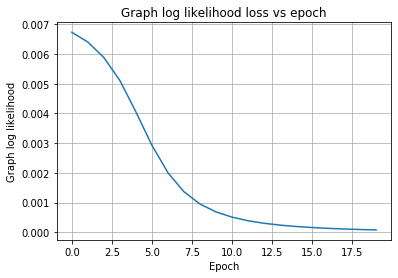

In [8]:
plt.title("Graph log likelihood loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Graph log likelihood")
plt.grid()
plt.plot(history.history['loss'])
plt.show()

## Visualizing Embeddings

Now we use TSNE to visualize the embeddings.

In [27]:
nodelist = list(G.nodes())

inputs = layers.Input(batch_shape=(len(nodelist),), dtype='int64')
left_out = model.get_layer('LEFT_EMBEDDINGS')(inputs)
right_out = model.get_layer('RIGHT_EMBEDDINGS')(inputs)
out = layers.concatenate([left_out, right_out])

embedding_model = Model(inputs=inputs, outputs=out)
embeddings = embedding_model.predict(np.arange(len(nodelist)))

In [28]:
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None)
node_data.set_index(0, inplace=True)

labels = node_data[node_data.columns[-1]].loc[nodelist]

In [29]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

target_encoding = OneHotEncoder(sparse=False)

transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

emb_transformed['label'] = np.argmax(target_encoding.fit_transform(labels.values.reshape(-1, 1)), 1)

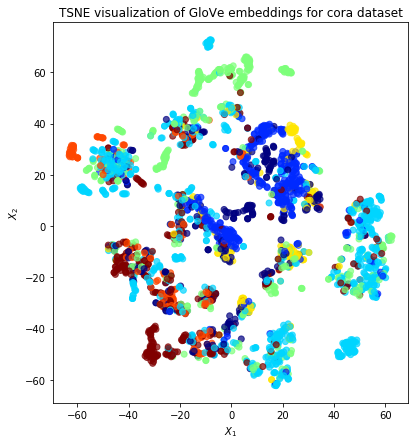

In [30]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GloVe embeddings for cora dataset'.format(transform.__name__))
plt.show()